In [20]:
import fastai
from fastai.vision.all import *
from tqdm import tqdm
from glob import glob
from sklearn.model_selection import train_test_split

import timm
import copy

from lightly.transforms.byol_transform import BYOLTransform, BYOLView1Transform, BYOLView2Transform
from lightly.models.modules import BYOLProjectionHead, BYOLPredictionHead
from lightly.models.utils import deactivate_requires_grad, update_momentum
from lightly.loss import NegativeCosineSimilarity
from lightly.utils.scheduler import cosine_schedule

In [21]:
SEED = 85
def seed_everything(seed):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed_everything(SEED)

In [22]:
# Paths
ZIP_PATH = '/cluster/home/bjorneme/projects/Data/chestX-ray14.zip'
EXTRACTED_PATH = '/cluster/home/bjorneme/projects/Data/chestX-ray14-extracted'

# Define parameters
SEED = 42

# Parameteres BYOL
LEARNING_RATE_BYOL = 0.06
BYOL_EPOCHS = 3
BATCH_SIZE_BYOL = 32
TEMPERATURE_BYOL = 0.5

# Device Configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [23]:
# Define Disease Labels
disease_labels = [
    'Atelectasis', 'Consolidation', 'Infiltration', 'Pneumothorax', 'Edema',
    'Emphysema', 'Fibrosis', 'Effusion', 'Pneumonia', 'Pleural_Thickening',
    'Cardiomegaly', 'Nodule', 'Mass', 'Hernia'
]

def load_labels(csv_path, image_path):
    """
    Loads and preprocesses the labels from the CSV file.
    Maps each image to its corresponding file path and binary labels for each disease.
    """

    # Read the CSV file containing labels
    labels_df = pd.read_csv(csv_path)

    # Create binary columns for each disease label
    for disease in disease_labels:
        labels_df[disease] = labels_df['Finding Labels'].str.contains(disease).astype(int)

    # Create a binary column for 'No Finding'
    labels_df['No_Finding'] = labels_df['Finding Labels'].apply(lambda x: 1 if 'No Finding' in x else 0)

    # Map image filenames to their full paths
    image_paths = glob(os.path.join(image_path, '**', 'images', '*.png'), recursive=True)
    img_path_dict = {os.path.basename(path): path for path in image_paths}

    # Add the full image path to the dataframe
    labels_df['Path'] = labels_df['Image Index'].map(img_path_dict)
    return labels_df

# Path to the labels CSV file
labels_csv_path = os.path.join(EXTRACTED_PATH, 'Data_Entry_2017.csv')

# Load and preprocess the labels
labels_df = load_labels(labels_csv_path, EXTRACTED_PATH)

In [24]:
labels_df=labels_df[labels_df['Finding Labels'] != 'No Finding']

In [25]:
# Split patients into training/validation and test sets
unique_patients = labels_df['Patient ID'].unique()
train_val_patients, test_patients = train_test_split(
    unique_patients, test_size=0.2, random_state=SEED
)

# Create training/validation and test dataframes
train_val_df = labels_df[labels_df['Patient ID'].isin(train_val_patients)].reset_index(drop=True)
test_df = labels_df[labels_df['Patient ID'].isin(test_patients)].reset_index(drop=True)

# Verify Split Sizes
print(f"Train size: {train_val_df.shape[0]}")
print(f"Test size: {test_df.shape[0]}")

Train size: 41466
Test size: 10293


# TODO

In [26]:
byol_transform = BYOLTransform(
    view_1_transform=BYOLView1Transform(input_size=224, gaussian_blur=0.0),
    view_2_transform=BYOLView2Transform(input_size=224, gaussian_blur=0.0),
)

In [27]:
class BYOL(nn.Module):
    def __init__(self):
        super().__init__()

        # The online network
        self.backbone = timm.create_model('coatnet_2_rw_224.sw_in12k_ft_in1k')
        self.projection_head = BYOLProjectionHead(1000, 1024, 256)
        self.prediction_head = BYOLPredictionHead(256, 1024, 256)

        # The target network
        self.backbone_momentum = copy.deepcopy(self.backbone)
        self.projection_head_momentum = copy.deepcopy(self.projection_head)

        # Freeze the teacher network. Only update using EMA
        deactivate_requires_grad(self.backbone_momentum)
        deactivate_requires_grad(self.projection_head_momentum)

    def forward_student(self, x):
        # Forward pass student network
        y = self.backbone(x).flatten(start_dim=1)
        z = self.projection_head(y)
        p = self.prediction_head(z)
        return p

    def forward_teacher(self, x):
        # Forward pass teacher network
        y = self.backbone_momentum(x).flatten(start_dim=1)
        z = self.projection_head_momentum(y)
        return z.detach()

# Initalize BYOL model
model = BYOL().to(device)

In [28]:
class BYOLDataset(torch.utils.data.Dataset):
    """
    Custom Dataset for BYOL.
    Returns two augmented versions of each image.
    """
    def __init__(self, df, transform):
        self.df = df
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        # Get image path
        img_path = self.df.iloc[idx]['Path']

        # Load image using PIL and convert to RGB
        image = Image.open(img_path).convert("RGB")

        # Apply the BYOL transform to generate two augmented views
        view1, view2 = self.transform(image)

        return view1, view2

# Recreate SimCLR Dataset with the updated __getitem__ method
byol_dataset = BYOLDataset(train_val_df, transform=byol_transform)

In [29]:
byol_loader = DataLoader(
    byol_dataset,
    batch_size=BATCH_SIZE_BYOL,
    shuffle=True,
    num_workers=32,
    drop_last=True
)

In [30]:
criterion = NegativeCosineSimilarity()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE_BYOL)

In [31]:
"""
Trains the BYOL model.
"""
for epoch in range(BYOL_EPOCHS):
    break # TODO
    total_loss = 0.0
    progress_bar = tqdm(byol_loader, desc=f"BYOL Epoch {epoch+1}/{BYOL_EPOCHS}")
    momentum_val = cosine_schedule(epoch, BYOL_EPOCHS, 0.996, 1)
    for batch in progress_bar:
        x0, x1 = batch
        update_momentum(model.backbone, model.backbone_momentum, m=momentum_val)
        update_momentum(model.projection_head, model.projection_head_momentum, m=momentum_val)

        x0 = x0.to(device)
        x1 = x1.to(device)

        # Forward pass
        p0 = model.forward_student(x0)
        z0 = model.forward_teacher(x0)
        p1 = model.forward_student(x1)
        z1 = model.forward_teacher(x1)

        # Compute loss
        loss = 0.5 * (criterion(p0, z1) + criterion(p1, z0))

        # Backward pass and optimization
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        total_loss += loss.item()
        progress_bar.set_postfix({"Loss": loss.item()})

    avg_loss = total_loss / len(byol_loader)
    print(f"Epoch [{epoch+1}/{BYOL_EPOCHS}] - Average Loss: {avg_loss:.4f}")

In [32]:
# torch.save(model.state_dict(), '../../models/CoAtNet_BYOL.pth')
model.load_state_dict(torch.load('../../models/CoAtNet_BYOL.pth'))
print("BYOL encoder saved.")

/tmp/ipykernel_2292843/2165607611.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('../../models/CoAtNet_BYOL.pth'))


BYOL encoder saved.


# TODO

In [33]:
item_transforms = [
    Resize((224, 224)),
]

batch_transforms = [
    Flip(),
    Rotate(),
    Normalize.from_stats(*imagenet_stats),
]


def get_x(row):
    return row['Path']

def get_y(row):
    labels = row[disease_labels].tolist()
    return labels

dblock = DataBlock(
    blocks=(ImageBlock, MultiCategoryBlock(encoded=True,vocab=disease_labels)),
                   splitter=RandomSplitter(valid_pct=0.125, seed=SEED),
                   get_x=get_x,
                   get_y=get_y,
                   item_tfms=item_transforms,
                   batch_tfms=batch_transforms
                  )
dls = dblock.dataloaders(train_val_df, bs=16)
# print(dblock.datasets(train_val_merge).train)

In [34]:
# TODO: What should model_cls be?

In [35]:
from fastai.vision.all import *

cbs=[
    SaveModelCallback(monitor='valid_loss', min_delta=0.001, with_opt=True),
    EarlyStoppingCallback(monitor='valid_loss', min_delta=0.001, patience=5),
    ShowGraphCallback()
    ]

# Now create the Learner using the complete classification model.
learn = Learner(dls, model_cls,
                metrics=[accuracy_multi, F1ScoreMulti(), RocAucMulti()],
                cbs=cbs, wd=0.001)

learn.model = torch.nn.DataParallel(learn.model)

/cluster/home/bjorneme/.conda/envs/master_thesis/lib/python3.11/site-packages/fastai/learner.py:53: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(file, ma

intial learning rate= 3.630780702224001e-05


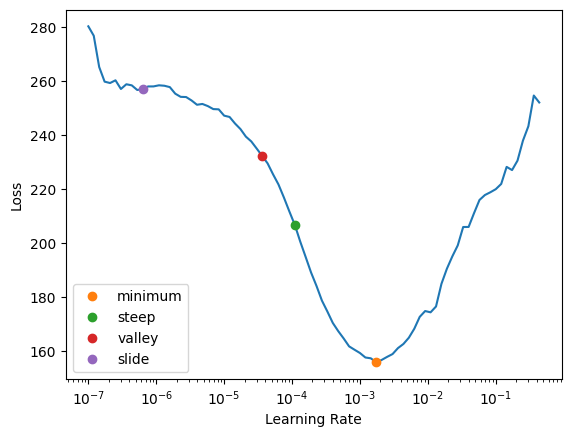

In [36]:
lrs = learn.lr_find(suggest_funcs=(minimum, steep, valley, slide))
print('intial learning rate=', lrs.valley)

In [37]:
learn.fine_tune(freeze_epochs=3,epochs=20, base_lr=0.01)

epoch,train_loss,valid_loss,accuracy_multi,f1_score,roc_auc_score,time


In [ ]:
learn.save('coatnet-70-10-20-split')

Path('models/coatnet-70-10-20-split.pth')

In [ ]:
from glob import glob

# Paths
ZIP_PATH = '/cluster/home/bjorneme/projects/Data/chestX-ray14.zip'
EXTRACTED_PATH = '/cluster/home/bjorneme/projects/Data/chestX-ray14-extracted'

# Define Disease Labels
disease_labels = [
    'Atelectasis', 'Consolidation', 'Infiltration', 'Pneumothorax', 'Edema',
    'Emphysema', 'Fibrosis', 'Effusion', 'Pneumonia', 'Pleural_Thickening',
    'Cardiomegaly', 'Nodule', 'Mass', 'Hernia'
]

def load_labels(csv_path, image_path):
    """
    Loads and preprocesses the labels from the CSV file.
    Maps each image to its corresponding file path and binary labels for each disease.
    """

    # Read the CSV file containing labels
    labels_df = pd.read_csv(csv_path)

    # Create binary columns for each disease label
    for disease in disease_labels:
        labels_df[disease] = labels_df['Finding Labels'].str.contains(disease).astype(int)

    # Create a binary column for 'No Finding'
    labels_df['No_Finding'] = labels_df['Finding Labels'].apply(lambda x: 1 if 'No Finding' in x else 0)

    # Map image filenames to their full paths
    image_paths = glob(os.path.join(image_path, '**', 'images', '*.png'), recursive=True)
    img_path_dict = {os.path.basename(path): path for path in image_paths}

    # Add the full image path to the dataframe
    labels_df['Path'] = labels_df['Image Index'].map(img_path_dict)
    return labels_df

# Path to the labels CSV file
labels_csv_path = os.path.join(EXTRACTED_PATH, 'Data_Entry_2017.csv')

# Load and preprocess the labels
labels_df = load_labels(labels_csv_path, EXTRACTED_PATH)

In [ ]:
# Split patients into training/validation and test sets
unique_patients = labels_df['Patient ID'].unique()
train_val_patients, test_patients = train_test_split(
    unique_patients, test_size=0.2, random_state=SEED
)

# Create training/validation and test dataframes
train_val_df = labels_df[labels_df['Patient ID'].isin(train_val_patients)].reset_index(drop=True)
test_df = labels_df[labels_df['Patient ID'].isin(test_patients)].reset_index(drop=True)

# Verify Split Sizes
print(f"Train size: {train_val_df.shape[0]}")
print(f"Test size: {test_df.shape[0]}")

Train size: 89826
Test size: 22294


In [ ]:
item_transforms = [
    Resize((224, 224)),
]

batch_transforms = [
    Flip(),
    Rotate(),
    Normalize.from_stats(*imagenet_stats),
]


def get_x(row):
    return row['Path']

def get_y(row):
    labels = row[disease_labels].tolist()
    return labels

dblock = DataBlock(
    blocks=(ImageBlock, MultiCategoryBlock(encoded=True,vocab=disease_labels)),
                   splitter=RandomSplitter(valid_pct=0.125, seed=SEED),
                   get_x=get_x,
                   get_y=get_y,
                   item_tfms=item_transforms,
                   batch_tfms=batch_transforms
                  )
dls = dblock.dataloaders(train_val_df, bs=32)
# print(dblock.datasets(train_val_merge).train)

In [ ]:
from fastai.vision.all import *

cbs=[
    SaveModelCallback(monitor='valid_loss', min_delta=0.001, with_opt=True),
    EarlyStoppingCallback(monitor='valid_loss', min_delta=0.001, patience=2),
    ShowGraphCallback()
    ]

# Now create the Learner using the complete classification model.
learn = Learner(dls, model_cls,
                metrics=[accuracy_multi, F1ScoreMulti(), RocAucMulti()],
                cbs=cbs, wd=0.001)

learn.model = torch.nn.DataParallel(learn.model)

In [ ]:
learn.unfreeze()
learn.fit_one_cycle(5, slice(2e-5, 8e-5))

epoch,train_loss,valid_loss,accuracy_multi,f1_score,roc_auc_score,time


In [ ]:
learn.save('coatnet-stage2')
learn = learn.load('../models/coatnet-stage2')

**Evaluation**

In [ ]:
from sklearn.metrics import roc_auc_score

# Create a test dataloader
test_dl = dls.test_dl(test_df, with_labels=True)

# Get predictions and targets from the test set
# Use torch.sigmoid to convert to probabilities.
preds, targs = learn.get_preds(dl=test_dl, act=torch.sigmoid)

# Compute the macro-averaged ROC AUC score for multi-label classification
roc_auc = roc_auc_score(targs.cpu().numpy(), preds.cpu().numpy(), average="macro")
print(f"Test ROC AUC: {roc_auc:.4f}")


KeyboardInterrupt: 

**Evaluation with Test-time Augmentation (TTA)**

In [ ]:
# Create a test dataloader with labels
test_dl = dls.test_dl(test_df, with_labels=True)

# Use test time augmentation (TTA) to get predictions
tta_preds, tta_targs = learn.tta(dl=test_dl, n=25, beta=0.9)

# Apply the sigmoid activation to convert logits to probabilities
tta_preds = torch.sigmoid(tta_preds)

# Compute the macro-averaged ROC AUC score for multi-label classification
roc_auc = roc_auc_score(tta_targs.cpu().numpy(), tta_preds.cpu().numpy(), average="macro")
print(f"Test ROC AUC (TTA): {roc_auc:.4f}")

/cluster/home/bjorneme/.conda/envs/master_thesis/lib/python3.11/site-packages/fastai/learner.py:53: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(file, ma

Test ROC AUC (TTA): 0.8575
